# Within-host $\pi_W$ sanity checks

On this page we perform sanity checks on our [estimates of within-host nucleotide diversity $\pi_W$ from deep genome sequencing data](https://d-kwiat.github.io/gtg/within-host-pi.html).  We observe that $\pi_W$ has a strikingly bimodal distribution, with a high-$\pi_W$ peak and a low-$\pi_W$ peak.

We postulate that the low-$\pi_W$ peak represents transmission chains where there has been no recent superinfection or cotransmission.  We are particularly interested in this value because we can use it to estimate the quantum of transmission $Q$.

We would like to be sure that the low-$\pi_W$ peak is not an artefact of genotyping errors, which could potentially arise either during genome sequencing or in the subsequent data pipeline.  Ideally we would like to see data from replicated experiments but these are not currently available.  Here we perform some basic analyses to reassure ourselves that there is no obvious systematic artefact in our low-$\pi_W$ estimates. 

#### Source of the data

* Data are from the [MalariaGEN Pf6 dataset](https://www.malariagen.net/resource/26) which has data on 6,051,696 variants in 7,113 samples from 30 countries.
* We select variants that are high-quality biallelic coding SNPs (n = 502,221). High quality means 'filter_pass == True' & 'vqslod > 3'
* We select samples that passed QC (n = 5,970)
* We use the data on allele depth for reference and non-reference forms of these biallelic SNPs in individual samples, and from this we calculate within-host heterozygosity for each SNP in each sample.

#### We will use these files

`wiho_het.npy`
* Gives within-host heterozygosity for each SNP (n = 502,221) in each sample (n = 5,970).  
* As we have selected biallelic SNPs this is easy to calculate from allele depth data.
* Filename: `230318_wiho_het.npy`
* This is a large file - 11.7GB

`region`
* A list of geographical regions for 5,970 selected samples
* 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania
* Filename: `230316_region`

`het_per_snp`
* Mean within-host heterozygosity for each SNP, calculated from `wiho_het.npy`
* Filename: `230317_het_per_snp`

`het_per_sample`
* Mean within-host heterozygosity for each sample after filtering by SNP heterozygosity (typically <0.02) and by geographical region.
* Filenames:
  * All regions (5970 samples): `230317_het_per_sample_ALL`
  * Southeast Asia: `230316_het_per_sample_SEA`
  * Africa (3314 samples): `230317_het_per_sample_Africa`
  
`allele_depth_2.npy`
* dimension 0 = SNPs (n = 512,220) 
* dimension 1 = samples (n = 5,970)
* dimension 2 = read depth for ref allele [0] and alt allele [1]
* note that these are all biallelic coding SNPs
* Filename: `221221_selected_gt_2.npy`

In [1]:
# FOR RUNNING ON COLAB

#from google.colab import drive

#drive.mount('/content/drive')

#data_path = "/content/drive/My Drive/Colab Data/Pf6/"

In [2]:
# FOR RUNNING ON COLAB

#import numpy as np
#import json
#import math
#import matplotlib.pyplot as plt
#import statistics as stat

In [3]:
# FOR RUNNING LOCALLY

data_path = 'G:\\My Drive\\Colab Data\\Pf6\\'

import numpy as np
import json
import math
import matplotlib.pyplot as plt
import statistics as stat

In [ ]:
with open(data_path + "230317_het_per_sample_ALL", "r") as filepath:
    het_per_sample = json.load(filepath)
    
wiho_het = np.load(data_path + '230318_wiho_het.npy', mmap_mode = 'r')

allele_depth = np.load(data_path + '221221_selected_gt_2.npy', mmap_mode = 'r')

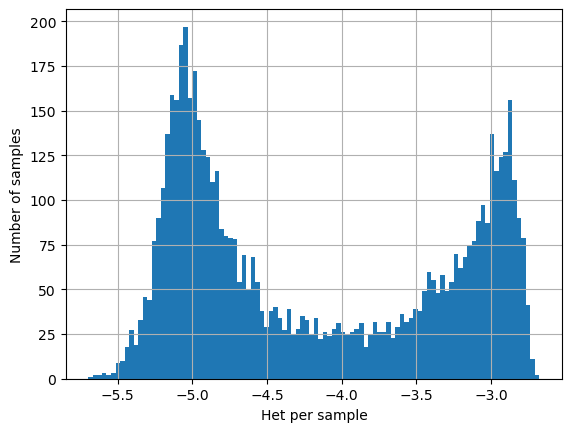

In [18]:
# All regions - only SNPs with het < 0.02

log_het_per_sample = [math.log(x, 10) for x in het_per_sample]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Het per sample')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

In [5]:
snp_count = wiho_het.shape[0]
sample_count = wiho_het.shape[1]

sample_het = np.array(het_per_sample)

lo_het = sample_het < 3e-5
hi_het = sample_het > 3e-4
med_het = (sample_het >= 3e-5) & (sample_het <= 3e-4)

In [6]:
allele_depth_lo = []
allele_depth_hi = []

for i in range(sample_count):
    
    if lo_het[i] == True:
    
        depth = np.mean(allele_depth[:, i, 0]) + np.mean(allele_depth[:, i, 1])

        allele_depth_lo.append(depth)

    if hi_het[i] == True:
    
        depth = np.mean(allele_depth[:, i, 0]) + np.mean(allele_depth[:, i, 1])

        allele_depth_hi.append(depth)
        
mean_depth_lo = stat.mean(allele_depth_lo)

mean_depth_hi = stat.mean(allele_depth_hi)

print("Mean allele depth is {0:4.1f} in low het samples and \
{1:4.1f} in high het samples".format(mean_depth_lo, mean_depth_hi))

Mean allele depth is 75.7 in low het samples and 80.3 in high het samples


The mean number of heterozygous SNPs in a low-het sample is 412.4


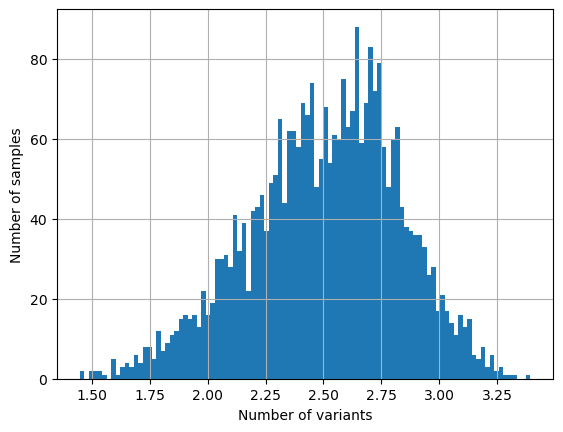

In [7]:
variants = []

for i in range(sample_count):
    
    if lo_het[i] == True:
        
        x = np.count_nonzero(wiho_het[: , i])
        
        variants.append(x)
        
mean_variants = stat.mean(variants)

print("The mean number of heterozygous SNPs in a low-het sample is {0:5.1f}".format(mean_variants))

log_variants = [math.log(x, 10) for x in variants]
plt.hist(log_variants, bins = 100)
plt.xlabel('Number of variants')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

In [9]:
minor_alleles = []

for i in range(50):
    
    alleles = []

    if lo_het[i] == True:
        
        for j in range(snp_count):
        
            x = allele_depth[j, i, 0]
            
            y = allele_depth[j, i, 1]
            
            z = min(x, y)
        
            if z != 0:
                
                alleles.append(z)
                
        minor_alleles.append(sum(alleles))
        
mean_minor_alleles = stat.mean(minor_alleles)

print("The mean number of minor allele reads in a low het \
sample is", str(mean_minor_alleles))

The mean number of minor allele reads in a low het sample is 1684


#### Understanding the difference between high het and low het samples

Look at SNPs that are present in both high and low het samples 
* What is their heterozygosity in low het samples vs high het samples?

How does this compare with heterozygosity of SNPs that are found only in low het samples?

In [10]:
# SNPs in both high and low het samples
#    what is their het in low het samples
#    what is their het in high het samples

snp_both_lo = []
snp_both_hi = []
snp_only_lo = []

for i in range(snp_count):
    
    if np.any(wiho_het[i, :][lo_het]) and np.any(wiho_het[i, :][hi_het]):
        
        mean_snp_het = stat.mean(wiho_het[i, :][lo_het]) 
        snp_both_lo.append(mean_snp_het)
        
        mean_snp_het = stat.mean(wiho_het[i, :][hi_het]) 
        snp_both_hi.append(mean_snp_het)
        
    if np.any(wiho_het[i, :][lo_het]) and not np.any(wiho_het[i, :][hi_het]):
        
        mean_snp_het = stat.mean(wiho_het[i, :][lo_het]) 
        snp_only_lo.append(mean_snp_het)

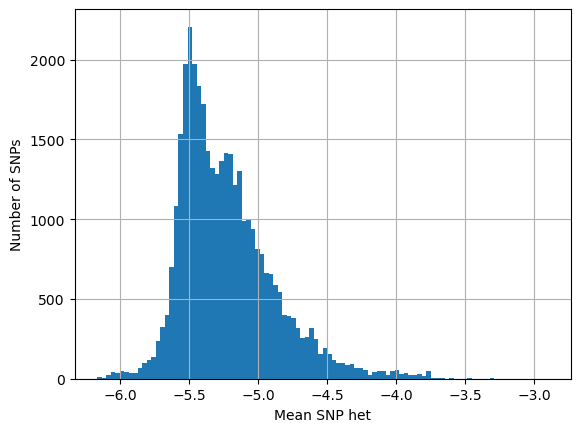

In [11]:
# SNPs present in low not high het samples
# looking at their het in low het samples
log_het_per_snp = [math.log(x, 10) for x in snp_only_lo]
plt.hist(log_het_per_snp, bins = 100)
plt.xlabel('Mean SNP het')
plt.ylabel('Number of SNPs')
plt.grid()
plt.show()

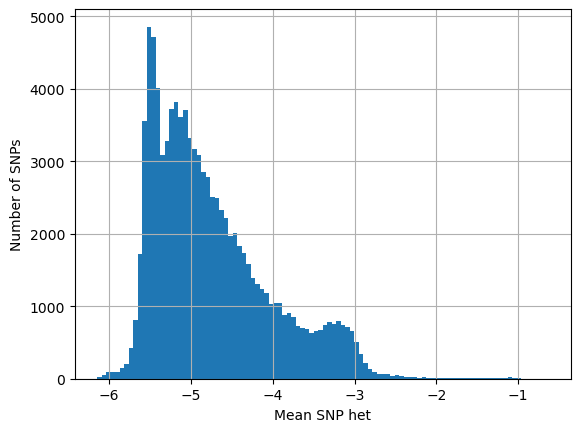

In [12]:
# SNPs present in both high and low het samples
# looking at their het in low het samples
log_het_per_snp = [math.log(x, 10) for x in snp_both_lo]
plt.hist(log_het_per_snp, bins = 100)
plt.xlabel('Mean SNP het')
plt.ylabel('Number of SNPs')
plt.grid()
plt.show()

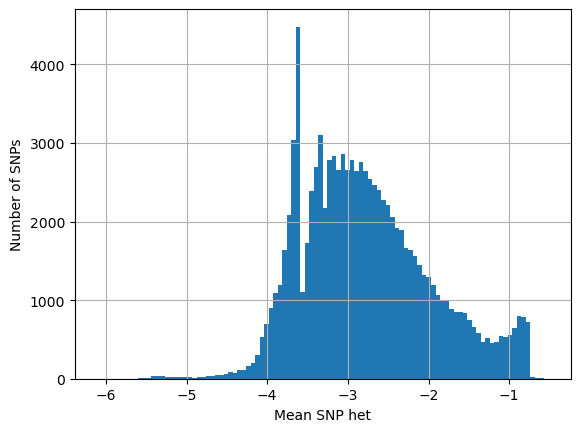

In [13]:
# SNPs present in both high and low het samples
# looking at their het in high het samples
log_het_per_snp = [math.log(x, 10) for x in snp_both_hi]
plt.hist(log_het_per_snp, bins = 100)
plt.xlabel('Mean SNP het')
plt.ylabel('Number of SNPs')
plt.grid()
plt.show()

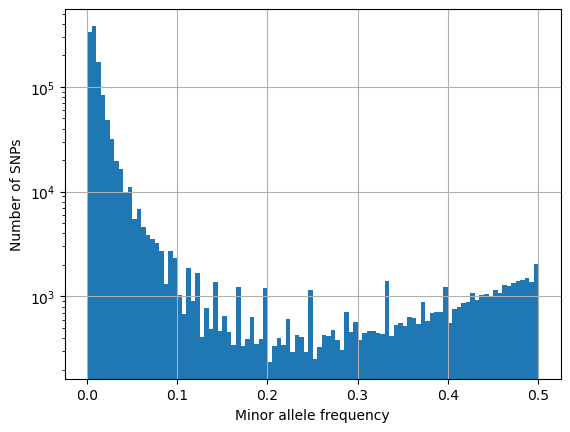

In [19]:
maf = []

for i in range(sample_count):

    if lo_het[i] == True:
    
        for j in range(snp_count):
        
            x = allele_depth[j, i, 0]
            
            y = allele_depth[j, i, 1]
            
            z = min(x, y)
            
            if z > 0:
    
                a = x + y
    
                if a != 0:
        
                    b = z/a
    
                    maf.append(b)
        
plt.hist(maf, bins = 100)
plt.xlabel('Minor allele frequency')
plt.ylabel('Number of SNPs')
plt.yscale("log")
plt.grid()
plt.show()